In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import os

from functions.utils import state_dict_to_vector

from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model
from model.kde_loss_Ba import Loss
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
device = 'cuda:1'

In [2]:
#dict with run_title : (num_events (in thousands), list of (num_epochs, dir_name))
all_runs = {
    'Adam_18kevents':(18,
                      [(100, 'baileyds100ep_DDplus_fromstart'),
                      (150, 'baileyds150ep_DDplus_iter2'),
                      (200, 'baileyds200ep_DDplus_iter3'),
                      (200, 'baileyds250ep_DDplus_iter4'),
                      (200, 'baileyds200ep_DDplus_iter5') 
                      ]),
    'Adam_18kevents_lrsched_at_iter4':(18,
                      [(100, 'baileyds100ep_DDplus_fromstart'),
                      (150, 'baileyds150ep_DDplus_iter2'),
                      (200, 'baileyds200ep_DDplus_iter3'),
                      (200, 'baileyds200ep_DDplus_iter4_lrstepschedule'),
                      (200, 'baileyds200ep_DDplus_iter5_lrstepschedulecontinued'),
                      (200, 'baileyds200ep_DDplus_iter6_lrstepschedulecontinued2')
                      ]),
    'Adam_18kevents_carefulAdam_at_iter4':(18,
                                          [(100, 'baileyds100ep_DDplus_fromstart'),
                                          (150, 'baileyds150ep_DDplus_iter2'),
                                          (200, 'baileyds200ep_DDplus_iter3'),
                                          (304, 'baileyds400ep_DDplus_iter4_carefulAdam')
                                          ]),
    'Adam_18kevents_nobiasadjust':(18,
                         [(200, 'baileyds200ep_DDplus_fromstart_nobiasadjust')
                         ]),
    'Adam_160kevents':(160,
                       [(25, 'GoodVersion_DDplus_iter0_Adam_160kevents'),
                        (25, 'GoodVersion_DDplus_iter1_Adam_160kevents'),
                        (25, 'GoodVersion_DDplus_iter2_Adam_160kevents'),
                        (25, 'GoodVersion_DDplus_iter3_Adam_160kevents')
                      ]),
    'Adam_withEVE_160kevents':(160,
                              [(25, 'GoodVersion_DDplus_iter0_Adam_withEVE_160kevents')
                              ]),
    'carefulAdam_18kevents':(18,
                             [(200, 'GoodVersion_DDplus_iter0_carefulAdam_18kevents'),
                             (181, 'GoodVersion_DDplus_iter1_carefulAdam_18kevents'),
                             (200, 'GoodVersion_DDplus_iter2_carefulAdam_18kevents')
                             ]),
    'carefulAdam_80kevents':(80,
                             [(50, 'GoodVersion_DDplus_iter0_carefulAdam_80kevents'),
                             (50, 'GoodVersion_DDplus_iter1_carefulAdam_80kevents'),
                             (50, 'GoodVersion_DDplus_iter2_carefulAdam_80kevents_betterlr')
                            ]),
    'carefulAdam_80kevents_losseps1e-4':(80,
                                        [(50, 'GoodVersion_DDplus_iter0_carefulAdam_80kevents_1e-4loss')
                                        ]),
    'carefulAdam_160kevents':(160,
                              [(25, 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'),
                              (25, 'GoodVersion_DDplus_iter1_carefulAdam_160kevents'),
                               (25, 'GoodVersion_DDplus_iter2_carefulAdam_160kevents'),
                               (25, 'GoodVersion_DDplus_iter3_carefulAdam_160kevents')
                            ]),
    'carefulAdam_320kevents':(320, 
                              [(25, 'GoodVersion_DDplus_iter0_carefulAdam_320kevents_1')
                              ]),
    'fixedcarefulAdam_18kevents':(18,
                                  [(158, 'GoodVersion_DDplus_iter0_fixedcarefulAdam_18kevents')
                                 ]),
    'fixedcarefulAdam_80kevents':(80,
                                  [(50, 'GoodVersion_DDplus_iter0_fixedcarefulAdam_80k')
                                 ]),
    'careful2Adam_160kevents':(160,
                                   [(25, 'GoodVersion_DDplus_iter0_fixedcarefulAdam_160kevents'),
                                   (25, 'GoodVersion_DDplus_iter1_fixedcarefulAdam_160kevents')
                                  ]),
    'adaptive_carefulAdam_80kevents':(80,
                              [(50, 'GoodVersion_DDplus_iter0_adaptivenet_carefulAdam_80kevents_1'),
                               (50, 'GoodVersion_DDplus_iter1_adaptivenet_carefulAdam_80kevents_1')
                              ]),
    'adaptive2_carefulAdam_80kevents':(80,
                              [(50, 'GoodVersion_DDplus_iter0_adaptivenet2_carefulAdam_80kevents_1'),
                               (50, 'GoodVersion_DDplus_iter1_adaptivenet2_carefulAdam_80kevents_1')
                              ])
    
    }

#to quickly call runs via number
run_names = {}
for i,key in enumerate(list(all_runs)):
    print(i, ':', key)
    run_names[i] = key

0 : Adam_18kevents
1 : Adam_18kevents_lrsched_at_iter4
2 : Adam_18kevents_carefulAdam_at_iter4
3 : Adam_18kevents_nobiasadjust
4 : Adam_160kevents
5 : Adam_withEVE_160kevents
6 : carefulAdam_18kevents
7 : carefulAdam_80kevents
8 : carefulAdam_80kevents_losseps1e-4
9 : carefulAdam_160kevents
10 : carefulAdam_320kevents
11 : fixedcarefulAdam_18kevents
12 : fixedcarefulAdam_80kevents
13 : careful2Adam_160kevents
14 : adaptive_carefulAdam_80kevents
15 : adaptive2_carefulAdam_80kevents


In [3]:
#Select runs to plot
runs = [i for i in range(len(all_runs))]
#[0, 1, 2] #18k
#[7, 14] #80k
#[4, 9] #160k
#

run_labels = [run_names[i] for i in runs]

#now to generate list of paths to the stored model dicts
dict_paths = []
num_epochs = []
for run_label in run_labels:
    these_paths = []
    this_num_epochs = 0
    dir_tuples = all_runs[run_label][1]
    for dir_tuple in dir_tuples:
        
        this_num_epochs += dir_tuple[0]
        dir_name = dir_tuple[1]
        for j in range(dir_tuple[0]):
            #print('ML/' + dir_names[i] + '/' + dir_names[i] + '_%i.pyt'%(j))
            these_paths.append('baileyds/DDplus/' + dir_name + '/' + dir_name + '_%i.pyt'%(j))
    dict_paths.append(these_paths)
    num_epochs.append(this_num_epochs)   
    
#print(dict_paths)

In [4]:
for paths in dict_paths:
    for filepath in paths:
        assert os.path.exists(filepath) == True

In [5]:
val_data = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=64,
                            #device=device,
                            #slice = slice(None, 2000)
                           )

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

In [6]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model.to(device)
loss_fn = Loss(epsilon=3e-5)

In [7]:
def train_loss(dataloader, model, loss_fn):
    model.train()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

def eval_loss(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

In [8]:
eval_losses = []

scan_sizes = {18:20, 80:5, 160:2, 320:1}

for i,paths in enumerate(dict_paths):
    print('On run:', run_labels[i])
    these_train_losses = []
    these_eval_losses = []
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    print(f'{all_runs[run_labels[i]][0]}k events -> scan size = {scan_size}')
    for ep in np.arange(0, num_epochs[i], scan_size):
        print("Epoch:", ep, '/', num_epochs[i])
        state_dict = torch.load(paths[ep], map_location=device)
        model.load_state_dict(state_dict)
#         start_time = time.time()
#         these_train_losses.append(train_loss(train_data, model, loss_fn))
#         print("Train loss time:", time.time()-start_time)
        start_time = time.time()
        these_eval_losses.append(eval_loss(val_data, model, loss_fn))
        print("Eval loss time:", time.time()-start_time)
        print('#############################################')
    #eval_losses.append(these_eval_losses)
    #add the last values if not added
    if ep != (len(paths)-1):
        ep = (len(paths)-1)
        print("Epoch:", ep, '/', num_epochs[i])
        state_dict = torch.load(paths[ep], map_location=device)
        model.load_state_dict(state_dict)
#         start_time = time.time()
#         these_train_losses.append(train_loss(train_data, model, loss_fn))
#         print("Train loss time:", time.time()-start_time)
        start_time = time.time()
        these_eval_losses.append(eval_loss(val_data, model, loss_fn))
        print("Eval loss time:", time.time()-start_time)
        print('#############################################')
    eval_losses.append(these_eval_losses)
    
with open('various_DDplus_savedloss.txt', 'w') as f:
    for i in range(len(dict_paths)):
        this_loss = eval_losses[i]
        for j in range(len(this_loss)):
            f.write(str(this_loss[j]))
            if j+1 in range(len(this_loss)):
                f.write(',')
        if i+1 in range(len(dict_paths)):
            f.write('\n')

On run: Adam_18kevents
18k events -> scan size = 20
Epoch: 0 / 850
Eval loss time: 13.014182090759277
#############################################
Epoch: 20 / 850
Eval loss time: 12.596233129501343
#############################################
Epoch: 40 / 850
Eval loss time: 12.710535049438477
#############################################
Epoch: 60 / 850
Eval loss time: 12.762590885162354
#############################################
Epoch: 80 / 850
Eval loss time: 12.823292255401611
#############################################
Epoch: 100 / 850
Eval loss time: 12.93080472946167
#############################################
Epoch: 120 / 850
Eval loss time: 12.905224084854126
#############################################
Epoch: 140 / 850
Eval loss time: 12.822414636611938
#############################################
Epoch: 160 / 850
Eval loss time: 12.7610502243042
#############################################
Epoch: 180 / 850
Eval loss time: 12.644840240478516
#######################

Eval loss time: 12.603513717651367
#############################################
Epoch: 800 / 1050
Eval loss time: 12.625723361968994
#############################################
Epoch: 820 / 1050
Eval loss time: 12.616570949554443
#############################################
Epoch: 840 / 1050
Eval loss time: 12.587633609771729
#############################################
Epoch: 860 / 1050
Eval loss time: 12.52210021018982
#############################################
Epoch: 880 / 1050
Eval loss time: 12.495117902755737
#############################################
Epoch: 900 / 1050
Eval loss time: 12.621515274047852
#############################################
Epoch: 920 / 1050
Eval loss time: 12.401762247085571
#############################################
Epoch: 940 / 1050
Eval loss time: 12.604921340942383
#############################################
Epoch: 960 / 1050
Eval loss time: 12.395126581192017
#############################################
Epoch: 980 / 1050
Eval loss t

Eval loss time: 12.752803325653076
#############################################
Epoch: 36 / 100
Eval loss time: 12.859304904937744
#############################################
Epoch: 38 / 100
Eval loss time: 12.882608413696289
#############################################
Epoch: 40 / 100
Eval loss time: 12.822964668273926
#############################################
Epoch: 42 / 100
Eval loss time: 12.604460000991821
#############################################
Epoch: 44 / 100
Eval loss time: 12.766087770462036
#############################################
Epoch: 46 / 100
Eval loss time: 12.706733226776123
#############################################
Epoch: 48 / 100
Eval loss time: 12.649394750595093
#############################################
Epoch: 50 / 100
Eval loss time: 12.709263801574707
#############################################
Epoch: 52 / 100
Eval loss time: 12.845820665359497
#############################################
Epoch: 54 / 100
Eval loss time: 12.75481247901

Eval loss time: 12.789237976074219
#############################################
Epoch: 35 / 150
Eval loss time: 12.733113765716553
#############################################
Epoch: 40 / 150
Eval loss time: 12.691025972366333
#############################################
Epoch: 45 / 150
Eval loss time: 12.61105990409851
#############################################
Epoch: 50 / 150
Eval loss time: 12.861127614974976
#############################################
Epoch: 55 / 150
Eval loss time: 12.643315076828003
#############################################
Epoch: 60 / 150
Eval loss time: 12.701832056045532
#############################################
Epoch: 65 / 150
Eval loss time: 12.638974666595459
#############################################
Epoch: 70 / 150
Eval loss time: 12.860894441604614
#############################################
Epoch: 75 / 150
Eval loss time: 12.771636247634888
#############################################
Epoch: 80 / 150
Eval loss time: 12.772804737091

Eval loss time: 12.54905366897583
#############################################
Epoch: 98 / 100
Eval loss time: 12.798052549362183
#############################################
Epoch: 99 / 100
Eval loss time: 12.811851263046265
#############################################
On run: carefulAdam_320kevents
320k events -> scan size = 1
Epoch: 0 / 25
Eval loss time: 12.822664976119995
#############################################
Epoch: 1 / 25
Eval loss time: 12.722090005874634
#############################################
Epoch: 2 / 25
Eval loss time: 12.72999906539917
#############################################
Epoch: 3 / 25
Eval loss time: 12.602362394332886
#############################################
Epoch: 4 / 25
Eval loss time: 12.767916679382324
#############################################
Epoch: 5 / 25
Eval loss time: 12.52222752571106
#############################################
Epoch: 6 / 25
Eval loss time: 12.796135663986206
#############################################
Epo

Eval loss time: 12.715010166168213
#############################################
Epoch: 50 / 100
Eval loss time: 12.719413757324219
#############################################
Epoch: 55 / 100
Eval loss time: 12.645675659179688
#############################################
Epoch: 60 / 100
Eval loss time: 12.756229400634766
#############################################
Epoch: 65 / 100
Eval loss time: 12.818889379501343
#############################################
Epoch: 70 / 100
Eval loss time: 12.714135646820068
#############################################
Epoch: 75 / 100
Eval loss time: 12.870801210403442
#############################################
Epoch: 80 / 100
Eval loss time: 12.774096488952637
#############################################
Epoch: 85 / 100
Eval loss time: 12.816302299499512
#############################################
Epoch: 90 / 100
Eval loss time: 12.7267587184906
#############################################
Epoch: 95 / 100
Eval loss time: 12.7530474662780

In [9]:
eval_losses = []
with open('various_DDplus_savedloss.txt', 'r') as f:
    idx = 0
    for line in f:
        if idx in runs:
            line.split(',')
            eval_losses.append([float(val) for val in line.split(',')])
        idx += 1

<IPython.core.display.Javascript object>


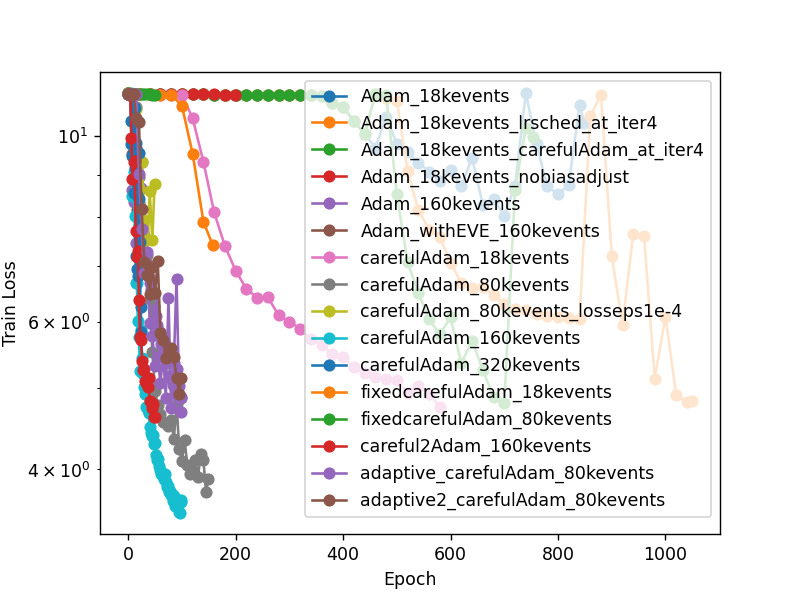

<IPython.core.display.Javascript object>


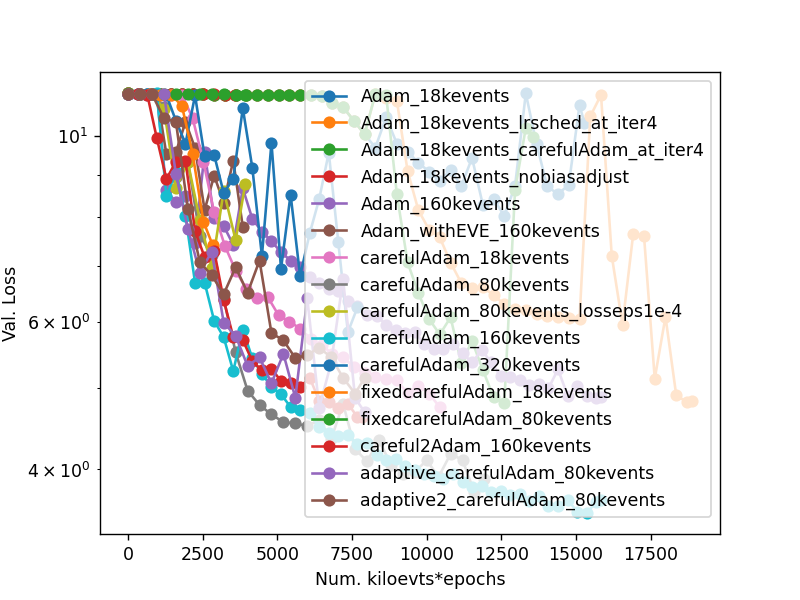

In [10]:
plt.figure()
for i in range(len(dict_paths)):
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    if np.arange(0, num_epochs[i], scan_size)[-1] != (num_epochs[i]-1):
        plt.plot(np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.yscale('log')
plt.legend()

#now approx. normalizing x axis for comp time
plt.figure()
for i in range(len(dict_paths)):
    num_evts = all_runs[run_labels[i]][0]
    scan_size = scan_sizes[all_runs[run_labels[i]][0]]
    if np.arange(0, num_epochs[i], scan_size)[-1] != num_epochs[i]-1:
        plt.plot(num_evts*np.append(np.arange(0, num_epochs[i], scan_size), [num_epochs[i]-1]), eval_losses[i], 'o-', label=run_labels[i])
    else:
        plt.plot(num_evts*np.arange(0, num_epochs[i], scan_size), eval_losses[i], 'o-', label=run_labels[i])
plt.xlabel("Num. kiloevts*epochs")
plt.ylabel("Val. Loss")
plt.yscale('log')
plt.legend()